In [ ]:
! pip install --quiet "lightning"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 14.0 MB/s eta 0:00:00


In [ ]:
!wget https://figshare.com/ndownloader/files/29138334?private_link=0c1dfc3be66eb622cf85

--2024-11-18 00:14:40--  https://figshare.com/ndownloader/files/29138334?private_link=0c1dfc3be66eb622cf85
Resolving figshare.com (figshare.com)... 108.128.29.31, 52.17.150.186, 2a05:d018:1f4:d000:1e75:fe49:25f0:9a08, ...
Connecting to figshare.com (figshare.com)|108.128.29.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 297225812 (283M) [application/zip]
Saving to: ‘29138334?private_link=0c1dfc3be66eb622cf85’

29138334?private_li 100%[===================>] 283.46M  13.8MB/s    in 23s     

2024-11-18 00:15:04 (12.4 MB/s) - ‘29138334?private_link=0c1dfc3be66eb622cf85’ saved [297225812/297225812]



In [ ]:
!mv 29138334?private_link=0c1dfc3be66eb622cf85 cifar.zip
!unzip cifar.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/train/Truck/aerial_ladder_truck_s_000001.png  
  inflating: images/train/Truck/aerial_ladder_truck_s_000006.png  
  inflating: images/train/Truck/aerial_ladder_truck_s_000015.png  
  inflating: images/train/Truck/aerial_ladder_truck_s_000030.png  
  inflating: images/train/Truck/aerial_ladder_truck_s_000042.png  
  inflating: images/train/Truck/aerial_ladder_truck_s_000063.png  
  inflating: images/train/Truck/aerial_ladder_truck_s_000068.png  
  inflating: images/train/Truck/aerial_ladder_truck_s_000074.png  
  inflating: images/train/Truck/aerial_ladder_truck_s_000075.png  
  inflating: images/train/Truck/aerial_ladder_truck_s_000076.png  
  inflating: images/train/Truck/aerial_ladder_truck_s_000079.png  
  inflating: images/train/Truck/aerial_ladder_truck_s_000080.png  
  inflating: images/train/Truck/aerial_ladder_truck_s_000083.png  
  inflating: images/train/Truck/aerial_ladder_truck_s_000087.png  
  inflating

In [ ]:
from glob import glob  # For file path matching and retrieval
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations on arrays
import os  # For operating system interface
import lightning.pytorch as L  # For PyTorch Lightning functionality
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping  # Model callbacks
from lightning.pytorch.callbacks import ModelSummary  # For summarizing model architecture
import torchmetrics  # For PyTorch metrics computation
import torch  # For PyTorch deep learning framework
from torch import nn  # For building neural network modules
import torchvision  # For computer vision utilities and datasets
from torchvision import transforms  # For data transformations
import torchvision.transforms.functional as F  # Functional transformations
import matplotlib.pyplot as plt  # For plotting graphs
from sklearn.model_selection import train_test_split  # For data splitting
import random  # For random number generation
import torch
from torchvision import transforms

def set_seed(seed: int = 0) -> None:
    """Set random seed for reproducibility across numpy, random, torch, and CUDA."""
    np.random.seed(seed)  # Seed for numpy operations
    random.seed(seed)  # Seed for random module
    torch.manual_seed(seed)  # Seed for PyTorch on CPU
    torch.cuda.manual_seed(seed)  # Seed for PyTorch on CUDA GPU

    # Ensure reproducibility on CuDNN backend
    torch.backends.cudnn.deterministic = True  # Disable nondeterministic algorithms
    torch.backends.cudnn.benchmark = False  # Disable performance optimizations for determinism

    # Set a fixed value for the hash seed for reproducibility
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")  # Confirm seed setting

# Set default seed for reproducibility
set_seed()

Random seed set as 0


In [ ]:
test_path = "/content/cifar10_raw/images/test/"  # Path to test dataset
train_path = "/content/cifar10_raw/images/train/"  # Path to training dataset

# List all file or directory names in the training path directory
list_ = [name for name in os.listdir(train_path)]
string2int = {name: index for index, name in enumerate(list_)}
def get_path(path):
    """Generate a list of dictionaries with image paths, labels, and class names for a given dataset path."""
    paths = []
    for name in list_:
        # Retrieve all .jpg files within each subdirectory under the given path
        l = glob(f"{path}{name}/*.png")

        # Append each image's path and its label (converted to int) to the paths list
        for i in l:
            paths.append({
                "name": name,
                "path": i,
                "label": string2int[name]
            })

    return paths

# Generate lists of paths with labels for both training and validation datasets
train_paths = get_path(train_path)
test_paths = get_path(test_path)
test_paths, _ = train_test_split(test_paths, train_size=0.4, random_state=0)
train_paths, _ = train_test_split(train_paths, train_size=0.4, random_state=0)
train_paths, val_paths = train_test_split(train_paths, test_size=0.2, random_state=0)

In [ ]:
class DataSet(torch.utils.data.Dataset):
    """Custom Dataset for loading images and their corresponding labels."""

    def __init__(self, features, transform=None):
        """Initialize the dataset with features and optional transformations.

        Args:
            features (list): List of dictionaries containing image paths and labels.
            transform (callable, optional): Optional transform to be applied on the images.
        """
        super(DataSet, self).__init__()
        self.features = features  # Store the list of features (paths and labels)
        self.transform = transform  # Store the transformation if provided

    def __len__(self):
        """Return the total number of samples in the dataset."""
        return len(self.features)

    def __getitem__(self, idx):
        """Retrieve an item from the dataset given an index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            dict: A dictionary containing the image tensor and its corresponding label.
        """
        # Get the path of the image based on the index
        paths = self.features[idx]["path"]

        # Read the image from the path
        images = torchvision.io.read_image(paths)

        # Convert grayscale image to 3 channels by stacking
        #images = torch.stack([images[0], images[0], images[0]], 0)

        # Apply transformations if any
        if self.transform is not None:
            images = self.transform(images)

        # Retrieve the label for the current index
        label = torch.tensor(self.features[idx]["label"])

        return {"images": images, "labels": label}

# Instantiate the dataset
train_dataset = DataSet(train_paths)
test_dataset = DataSet(test_paths)
val_dataset = DataSet(val_paths)

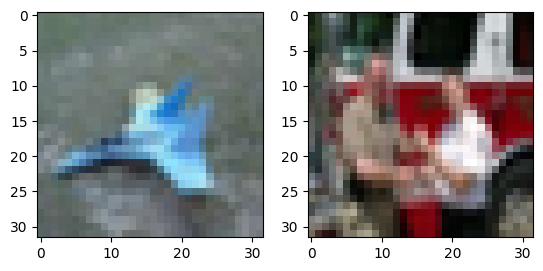

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as F

def show(imgs):
    """
    Display a list of images in a single row.

    Parameters:
        imgs (list or single image): List of images or a single image tensor.
    """
    # Ensure imgs is a list for consistent processing
    if not isinstance(imgs, list):
        imgs = [imgs]

    # Create subplots with one column per image
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)

    # Iterate through images and display each one
    for i, img in enumerate(imgs):
        img = img.detach()  # Detach from computation graph (if tensor)
        img = F.to_pil_image(img)  # Convert tensor to PIL image
        axs[0, i].imshow(np.asarray(img))  # Display image in subplot

# Initialize an iterator for the test dataset
data_iter = iter(test_dataset)

# Display the first two images from the test dataset
show([next(data_iter)["images"], next(data_iter)["images"]])


#### **code lai mang resnet 101**

In [ ]:
# Define the Residual Block used in ResNet
class ResidualBlock(nn.Module):
    def __init__(self, c_in, c_out, stride=1, downsample=None):
        super().__init__()

        # Define the main convolutional block with three layers
        self.conv_block = nn.Sequential(
            # First layer: 1x1 convolution, reduces number of channels to c_out
            nn.Conv2d(c_in, c_out, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU(inplace=True),

            # Second layer: 3x3 convolution, maintains channel size at c_out
            nn.Conv2d(c_out, c_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU(inplace=True),

            # Third layer: 1x1 convolution, expands channels to c_out * 4
            nn.Conv2d(c_out, c_out * 4, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(c_out * 4),
        )

        # Define downsampling layer if needed to match input/output dimensions
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x  # Save the input as identity for the residual connection
        out = self.conv_block(x)  # Pass input through main convolutional block

        # If downsample layer is defined, apply it to the identity
        if self.downsample:
            identity = self.downsample(x)

        # Add the residual (identity) to the output of the conv block
        out += identity
        out = self.relu(out)  # Apply ReLU to the combined output
        return out


# Define the ResNet101 model as a PyTorch Lightning module
class ResNet101(L.LightningModule):
    def __init__(self, num_classes=10):
        super(ResNet101, self).__init__()
        self.loss = torch.nn.CrossEntropyLoss()
        # Initial number of input channels
        self.in_channels = 64
        self.num_classes = num_classes

        # Initial layers before the main ResNet blocks
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Define ResNet layers, each layer contains a certain number of blocks
        self.layer1 = self._make_layer(64, 3)  # Layer 1 with 3 blocks
        self.layer2 = self._make_layer(128, 4, stride=2)  # Layer 2 with 4 blocks
        self.layer3 = self._make_layer(256, 23, stride=2)  # Layer 3 with 23 blocks
        self.layer4 = self._make_layer(512, 3, stride=2)  # Layer 4 with 3 blocks

        # Pooling and fully connected layer for classification
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, self.num_classes)  # Output layer for classification

    def _make_layer(self, out_channels, blocks, stride=1):
        # Define downsampling if stride != 1 or input and output channels differ
        downsample = None
        if stride != 1 or self.in_channels != out_channels * 4:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * 4, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * 4),
            )

        # Create the list of blocks, starting with the downsampling block if needed
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * 4  # Update in_channels for the next block

        # Add remaining blocks without downsampling
        for _ in range(1, blocks):
            layers.append(ResidualBlock(self.in_channels, out_channels))

        return nn.Sequential(*layers)  # Return the layer as a sequential block

    def forward(self, x):
        # Initial convolution and pooling layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Pass through each ResNet layer
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Pool and flatten for fully connected layer
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'loss': loss, 'acc': accuracy}, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        val_loss = self.loss(y_hat, y)
        val_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'val_loss': val_loss, 'val_acc': val_accuracy}, prog_bar=True)
        return val_loss

    def test_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        test_loss = self.loss(y_hat, y)
        test_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'test_loss': test_loss, 'test_acc': test_accuracy}, prog_bar=True)
        return test_loss

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x, _ = batch['images'], batch['labels']
        y_hat = self(x)
        probabilities = torch.softmax(y_hat, dim=1)
        predicted_labels = torch.argmax(probabilities, dim=1)
        return {"y_pred": predicted_labels}

    def configure_optimizers(self):
        # Define optimizer (Adam) with a specified learning rate
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


#### **train model với epoch = 6 và  batch_size = 32**

In [ ]:
# Define batch size and number of workers for DataLoader
batch_size = 32
num_workers = 2

# Define transformations for training images
train_transforms = transforms.Compose([
    transforms.ToPILImage(),  # Convert image to PIL format
    transforms.Resize((224, 224)),  # Resize image to 224x224
    transforms.RandomHorizontalFlip(),  # Apply random horizontal flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),  # Adjust image color properties
    transforms.ToTensor(),  # Convert image to tensor format
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Normalize using ImageNet mean and std
])

# Define transformations for test/validation images
test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Initialize datasets with corresponding transformations
train_dataset = DataSet(train_paths, transform=train_transforms)
test_dataset = DataSet(test_paths, transform=test_transforms)
val_dataset = DataSet(val_paths, transform=test_transforms)

# Create DataLoaders for each dataset
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, shuffle=False, batch_size=batch_size, num_workers=num_workers
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, shuffle=False, batch_size=batch_size, num_workers=num_workers
)


In [ ]:
model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=1)]

model = ResNet101()
trainer = L.Trainer(max_epochs=6, detect_anomaly=True, callbacks=callbacks)

trainer.fit(model, train_dataloader, val_dataloader)

INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
IN

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 500: 'val_acc' reached 0.30400 (best 0.30400), saving model to '/content/checkpoint/epoch=0-step=500.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 500: 'val_acc' reached 0.30400 (best 0.30400), saving model to '/content/checkpoint/epoch=0-step=500.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 1000: 'val_acc' reached 0.35100 (best 0.35100), saving model to '/content/checkpoint/epoch=1-step=1000.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 1000: 'val_acc' reached 0.35100 (best 0.35100), saving model to '/content/checkpoint/epoch=1-step=1000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 1500: 'val_acc' reached 0.39325 (best 0.39325), saving model to '/content/checkpoint/epoch=2-step=1500.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 1500: 'val_acc' reached 0.39325 (best 0.39325), saving model to '/content/checkpoint/epoch=2-step=1500.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 2000: 'val_acc' reached 0.46550 (best 0.46550), saving model to '/content/checkpoint/epoch=3-step=2000.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 2000: 'val_acc' reached 0.46550 (best 0.46550), saving model to '/content/checkpoint/epoch=3-step=2000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 2500: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 2500: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 3000: 'val_acc' reached 0.50825 (best 0.50825), saving model to '/content/checkpoint/epoch=5-step=3000.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 3000: 'val_acc' reached 0.50825 (best 0.50825), saving model to '/content/checkpoint/epoch=5-step=3000.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=6` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=6` reached.


#### **train model với epoch = 6 và  batch_size = 64**

In [ ]:
# Define batch size and number of workers for DataLoader
batch_size = 64
num_workers = 2

# Initialize datasets with corresponding transformations
train_dataset = DataSet(train_paths, transform=train_transforms)
test_dataset = DataSet(test_paths, transform=test_transforms)
val_dataset = DataSet(val_paths, transform=test_transforms)

# Create DataLoaders for each dataset
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, shuffle=False, batch_size=batch_size, num_workers=num_workers
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, shuffle=False, batch_size=batch_size, num_workers=num_workers
)


In [ ]:
model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=1)]

model = ResNet101()
trainer = L.Trainer(max_epochs=6, detect_anomaly=True, callbacks=callbacks)

trainer.fit(model, train_dataloader, val_dataloader)

INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
IN

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 250: 'val_acc' reached 0.32800 (best 0.32800), saving model to '/content/checkpoint/epoch=0-step=250.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 250: 'val_acc' reached 0.32800 (best 0.32800), saving model to '/content/checkpoint/epoch=0-step=250.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 500: 'val_acc' reached 0.40050 (best 0.40050), saving model to '/content/checkpoint/epoch=1-step=500.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 500: 'val_acc' reached 0.40050 (best 0.40050), saving model to '/content/checkpoint/epoch=1-step=500.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 750: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 750: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 1000: 'val_acc' reached 0.51250 (best 0.51250), saving model to '/content/checkpoint/epoch=3-step=1000.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 1000: 'val_acc' reached 0.51250 (best 0.51250), saving model to '/content/checkpoint/epoch=3-step=1000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 1250: 'val_acc' reached 0.58775 (best 0.58775), saving model to '/content/checkpoint/epoch=4-step=1250.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 1250: 'val_acc' reached 0.58775 (best 0.58775), saving model to '/content/checkpoint/epoch=4-step=1250.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 1500: 'val_acc' reached 0.63850 (best 0.63850), saving model to '/content/checkpoint/epoch=5-step=1500.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 1500: 'val_acc' reached 0.63850 (best 0.63850), saving model to '/content/checkpoint/epoch=5-step=1500.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=6` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=6` reached.


In [ ]:
trainer.test(model, dataloaders=test_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6445000171661377     │
│         test_loss         │    1.0107489824295044     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.0107489824295044, 'test_acc': 0.6445000171661377}]

#### **train model với epoch = 6 và bach_size = 128**

In [ ]:
# Define batch size and number of workers for DataLoader
batch_size = 128
num_workers = 2

# Define transformations for training images
train_transforms = transforms.Compose([
    transforms.ToPILImage(),  # Convert image to PIL format
    transforms.Resize((224, 224)),  # Resize image to 224x224
    transforms.RandomHorizontalFlip(),  # Apply random horizontal flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),  # Adjust image color properties
    transforms.ToTensor(),  # Convert image to tensor format
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Normalize using ImageNet mean and std
])

# Define transformations for test/validation images
test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Initialize datasets with corresponding transformations
train_dataset = DataSet(train_paths, transform=train_transforms)
test_dataset = DataSet(test_paths, transform=test_transforms)
val_dataset = DataSet(val_paths, transform=test_transforms)

# Create DataLoaders for each dataset
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, shuffle=False, batch_size=batch_size, num_workers=num_workers
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, shuffle=False, batch_size=batch_size, num_workers=num_workers
)


In [ ]:
model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=1)]

model = ResNet101()
trainer = L.Trainer(max_epochs=6, detect_anomaly=True, callbacks=callbacks)

trainer.fit(model, train_dataloader, val_dataloader)

INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
IN

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 98.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 97.06 MiB is free. Process 17217 has 14.65 GiB memory in use. Of the allocated memory 14.30 GiB is allocated by PyTorch, and 221.16 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

- **batch_size = 128 bị lỗi CUDA out of memory nên batch_size = 64 là tối ưu và đã dùng hết 16gb vram**

### **Thay BatchNorm ra sau activation function và so sánh kết quả**

In [ ]:
# Define the Residual Block used in ResNet
class ResidualBlock(nn.Module):
    def __init__(self, c_in, c_out, stride=1, downsample=None):
        super().__init__()

        # Define the main convolutional block with three layers
        self.conv_block = nn.Sequential(
            # First layer: 1x1 convolution, reduces number of channels to c_out
            nn.Conv2d(c_in, c_out, kernel_size=1, stride=stride, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(c_out),

            # Second layer: 3x3 convolution, maintains channel size at c_out
            nn.Conv2d(c_out, c_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(c_out),

            # Third layer: 1x1 convolution, expands channels to c_out * 4
            nn.Conv2d(c_out, c_out * 4, kernel_size=1, stride=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(c_out * 4),
        )

        # Define downsampling layer if needed to match input/output dimensions
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x  # Save the input as identity for the residual connection
        out = self.conv_block(x)  # Pass input through main convolutional block

        # If downsample layer is defined, apply it to the identity
        if self.downsample:
            identity = self.downsample(x)

        # Add the residual (identity) to the output of the conv block
        out += identity
        out = self.relu(out)  # Apply ReLU to the combined output
        return out


# Define the ResNet101 model as a PyTorch Lightning module
class ResNet101(L.LightningModule):
    def __init__(self, num_classes=10):
        super(ResNet101, self).__init__()
        self.loss = torch.nn.CrossEntropyLoss()
        # Initial number of input channels
        self.in_channels = 64
        self.num_classes = num_classes

        # Initial layers before the main ResNet blocks
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Define ResNet layers, each layer contains a certain number of blocks
        self.layer1 = self._make_layer(64, 3)  # Layer 1 with 3 blocks
        self.layer2 = self._make_layer(128, 4, stride=2)  # Layer 2 with 4 blocks
        self.layer3 = self._make_layer(256, 23, stride=2)  # Layer 3 with 6 blocks
        self.layer4 = self._make_layer(512, 3, stride=2)  # Layer 4 with 3 blocks

        # Pooling and fully connected layer for classification
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, self.num_classes)  # Output layer for classification

    def _make_layer(self, out_channels, blocks, stride=1):
        # Define downsampling if stride != 1 or input and output channels differ
        downsample = None
        if stride != 1 or self.in_channels != out_channels * 4:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * 4, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * 4),
            )

        # Create the list of blocks, starting with the downsampling block if needed
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * 4  # Update in_channels for the next block

        # Add remaining blocks without downsampling
        for _ in range(1, blocks):
            layers.append(ResidualBlock(self.in_channels, out_channels))

        return nn.Sequential(*layers)  # Return the layer as a sequential block

    def forward(self, x):
        # Initial convolution and pooling layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Pass through each ResNet layer
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Pool and flatten for fully connected layer
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'loss': loss, 'acc': accuracy}, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        val_loss = self.loss(y_hat, y)
        val_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'val_loss': val_loss, 'val_acc': val_accuracy}, prog_bar=True)
        return val_loss

    def test_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        test_loss = self.loss(y_hat, y)
        test_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'test_loss': test_loss, 'test_acc': test_accuracy}, prog_bar=True)
        return test_loss

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x, _ = batch['images'], batch['labels']
        y_hat = self(x)
        probabilities = torch.softmax(y_hat, dim=1)
        predicted_labels = torch.argmax(probabilities, dim=1)
        return {"y_pred": predicted_labels}

    def configure_optimizers(self):
        # Define optimizer (Adam) with a specified learning rate
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [ ]:
model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=1)]

model = ResNet101()
trainer = L.Trainer(max_epochs=6, detect_anomaly=True, callbacks=callbacks)

trainer.fit(model, train_dataloader, val_dataloader)

INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
IN

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 250: 'val_acc' reached 0.24825 (best 0.24825), saving model to '/content/checkpoint/epoch=0-step=250.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 250: 'val_acc' reached 0.24825 (best 0.24825), saving model to '/content/checkpoint/epoch=0-step=250.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 500: 'val_acc' reached 0.28450 (best 0.28450), saving model to '/content/checkpoint/epoch=1-step=500.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 500: 'val_acc' reached 0.28450 (best 0.28450), saving model to '/content/checkpoint/epoch=1-step=500.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 750: 'val_acc' reached 0.38225 (best 0.38225), saving model to '/content/checkpoint/epoch=2-step=750.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 750: 'val_acc' reached 0.38225 (best 0.38225), saving model to '/content/checkpoint/epoch=2-step=750.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 1000: 'val_acc' reached 0.38500 (best 0.38500), saving model to '/content/checkpoint/epoch=3-step=1000.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 1000: 'val_acc' reached 0.38500 (best 0.38500), saving model to '/content/checkpoint/epoch=3-step=1000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 1250: 'val_acc' reached 0.39800 (best 0.39800), saving model to '/content/checkpoint/epoch=4-step=1250.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 1250: 'val_acc' reached 0.39800 (best 0.39800), saving model to '/content/checkpoint/epoch=4-step=1250.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 1500: 'val_acc' reached 0.44375 (best 0.44375), saving model to '/content/checkpoint/epoch=5-step=1500-v1.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 1500: 'val_acc' reached 0.44375 (best 0.44375), saving model to '/content/checkpoint/epoch=5-step=1500-v1.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=6` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=6` reached.


In [ ]:
#Thay BatchNorm ra sau activation function
trainer.test(model, dataloaders=test_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4437499940395355     │
│         test_loss         │    1.6033506393432617     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.6033506393432617, 'test_acc': 0.4437499940395355}]

In [ ]:
# Đánh giá kết quả trên tập test của model 2
trainer.test(model, dataloaders=test_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6445000171661377     │
│         test_loss         │    1.0107489824295044     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.0107489824295044, 'test_acc': 0.6445000171661377}]

- **Đặt Batch Normalization trước Activation Function ở model 2 (BatchNorm → Activation) là cách tối ưu hơn trong bài này với test accuracy cao hơn đáng kể (64.45% so với 44.37%).**

#Bài tập
1. Code lại mạng resnet -101
2. Train resnet - 101 với số epochs là 6, thay đổi batchsize để dùng hết 16gb vram đã train được đánh giá kết quả trên tập test
3. Thay BatchNorm ra sau activation function và so sánh kết quả với trước model ở 2.
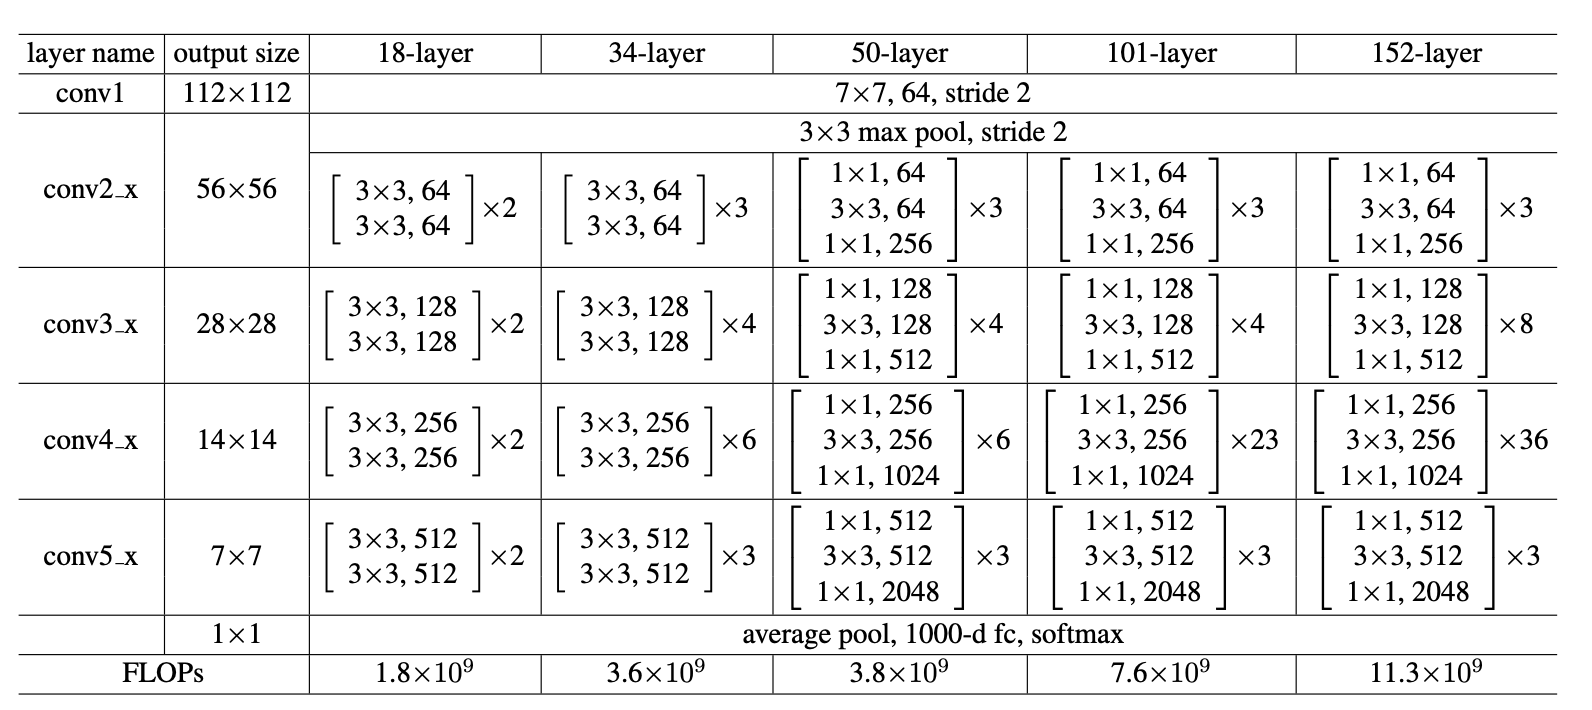